# CS146 LBA: Temperature & Precipitation in CABA 
### *In Better Understanding of Matanza Riachuelo Basin Floods*

## Part 1: Data in Buenos Aires 

### Background 

Within the past two months of my stay in Buenos Aires, I have worked 10 hours per week in a lab at Maimonides Universidad. Here, I have been researching the algae *C. Vulgaris* and its potential within biotechnology in bioremediating the Matanza Riachuelo Basin. This river runs along the southern border of CABA, the Autonomous City of Buenos Aires, a sector within the Buenos Aires Province.

The Matanza Riachuelo Basin, or its Rio Riachuelo, is one of the most polluted rivers in the world. Its call for bioremediation originates not just from the dangerous pollutants within the river, but from the rate at which the river is growing. Residents living next to and nearby the river risk flooding and contamination of their properties (Romero, 2019). Contributing factors to Rio Riachuelo's growth (in width) include the local geography, being the flatness of CABA land, that leads to pooling of water; and the amount of water, mediated by the contributing tributaries within the province and the levels of precipitation. Confirmed increase in temperature over time is known to influence precipitation, but this relationship in Buenos Aires has not been explored to my knowledge, consisting of publicly available data and research (Pol & Binyamin, 2014; Trenberth & Shea, 2005). 

This LBA aims to define and compare models of temperature vs. precipitation data in better understanding the contributor of precipitation in the Matanza Riachuelo Basin Floods. 

### Variables / Data Source

In comparing temperature and precipitation, I used publicly available data sets sourced from the Buenos Aires site where they have many datasets published. Here, I found temperature and precipitation data sets in csv files, each with 354 monly measurements from 1990 to 2020. I chose to model the mean temperature per month, measured in celcius; and the accumulated precipitation per month, measured in millimeters. 

I chose to define temperature as the independent or x-axis variable, as the upward trend of temperature is understood (Pol & Binyamin, 2014). Precipitation is both influenced by and an influencer of temperature, as precipitation can influence humidity and regional temperature and likewise, temperature can influence precipitation (Trenberth & Shea, 2005). Within this exploration, temperature remains on the x-axis for consistency purposes. 


#### Sources: 

BA Data. (N.D.) Accessed October 27, 2022. https://data.buenosaires.gob.ar/dataset/


Pol, M., & Binyamin, J. (2014). Impact of Climate Change and Variability on Wheat and Corn Production in Buenos Aires, Argentina. American Journal of Climate Change, 2014, 145-152. 10.4236/AJCC.2014.32013 

Romero, N. (2019, October 18). ¿Por qué se inunda la cuenca Matanza-Riachuelo?. Página 12. https://www.pagina12.com.ar/225939-por-que-se-inunda-la-cuenca-matanza-riachuelo 

Trenberth, K. & Shea, D. (2005). Relationship between precipitation and surface temperature. Geophys. 32. 10.1029/2005GL022760. 

In [132]:
#Importing packages and my two csvs, the precipitation and temperature datasets (with equal timed measurements)
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as sts
from scipy.special import logsumexp
import aesara.tensor as at

#Setting the default credible interval used by arviz
az.rcParams["stats.hdi_prob"] = 0.89

#Precipitation Data 
#https://data.buenosaires.gob.ar/dataset/registro-precipitaciones-ciudad
dP = pd.read_csv('historico_precipitaciones.csv')

#Temperature Data 
#https://data.buenosaires.gob.ar/dataset/registro-temperatura-ciudad
dT = pd.read_csv('historico_temperaturas.csv')

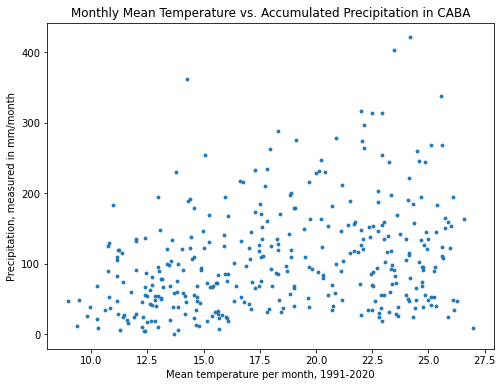

In [133]:
#Defining the two variables to use throughout the assignment, calling the CSV files

#Accumulated precipitation per month, measured in millimeters. 
mm = dP['mm']
#Mean temperature per month, measured in celsius using daily measurements during a given month. 
media = dT['media']

#Plotting data
plt.figure(figsize=(8, 6))
plt.scatter(media, mm, s=8)
plt.xlabel('Mean temperature per month, 1991-2020')
plt.ylabel('Precipitation, measured in mm/month')
plt.title('Monthly Mean Temperature vs. Accumulated Precipitation in CABA')
plt.show() 

## Part 2: Modeling Data
### Defining and Analyzing Normal and Student T Linear Regression Models

### Model Definition: Normal 

I chose to use a Uniform prior for c0 and a Normal prior for c1. 

For **c0**, I decided to use the Uniform distribution over the Normal because we don't know where the intercept will be from an intuitive perspective. I don't have local intuition about this, regarding that I have only lived here for two months. The Uniform distribution allows us to be agnostic about the intercept. This disregards the known that Precipitation traditionally correlates with Temperature, but I preferred the Uniform prior to an alternative broad Normal. 

For **c1**, I used the Normal distribution over the Uniform as to not limit the possibility of extreme slopes; the Normal assigns probability to the slope, while the Uniform sets explicit bounds. To not bias the slope, I chose a mean of 0. As the standard deviation influences the variation from the mean by ~2 sds, this affects how drastic our slope can be. Because I don't forsee too steep of a slope, I used a standard deviation of 10 as to bound, but not limit the possible slope.

**Sigma** is distributed normally, which assumes constant variance. Though there looks to be more noise on the right side of the plot (with data) dependent on x, modeling heteroscedastic noise is beyond the scope of this assignment. 

I set my **x** and **y** data according to my two csv datasets. 

This **likelihood function** is Normal, I will be comparing it to the Student T model.

In [134]:
#Using code from Class Sesssion 8, modified to fit my LBA. 

#Defining the model: 
with pm.Model() as normal_model: 
    
    #Priors 
    c0 = pm.Uniform('c0', lower=0, upper=100)  #choosing a generic Uniform distribution.
    c1 = pm.Normal('c1', mu=0, sigma=10)  #choosing a Normal distribution.
    sigma = pm.Uniform('sigma', lower=0, upper=100)
    
    #Data 
    x = pm.MutableData('x', media)
    y = pm.MutableData('y', mm)
    
    # Regression mean, this is the line fitting the two variables. 
    mu = pm.Deterministic('mu', c0 + c1 * x)
    
    # Likelihood, our Normal model
    pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y)
    
    #samples used for Part 2 
    tn = pm.sample(1000, tune=1000)
    
    #samples used for Part 3
    normal_inference = pm.sample()
    pm.sample_posterior_predictive(normal_inference, extend_inferencedata=True)

    


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/graysonmessenger/opt/anaconda3/lib/python3.9/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c0, c1, sigma]


/Users/graysonmessenger/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/graysonmessenger/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/graysonmessenger/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
The acceptance probability does not match the target. It is 0.708, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/graysonmessenger/opt/anaconda3/lib/python3.9/site-packages/pymc/aesaraf.py:1005: UserWarning: The parame

/Users/graysonmessenger/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
The acceptance probability does not match the target. It is 0.6474, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/graysonmessenger/opt/anaconda3/lib/python3.9/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c0, c1, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,20.495,11.376,1.173,35.664,0.571,0.432,409.0,409.0,1.00
c1,4.625,0.606,3.712,5.575,0.031,0.022,398.0,360.0,1.00
sigma,71.166,2.664,66.970,75.283,0.083,0.059,1028.0,1380.0,1.01


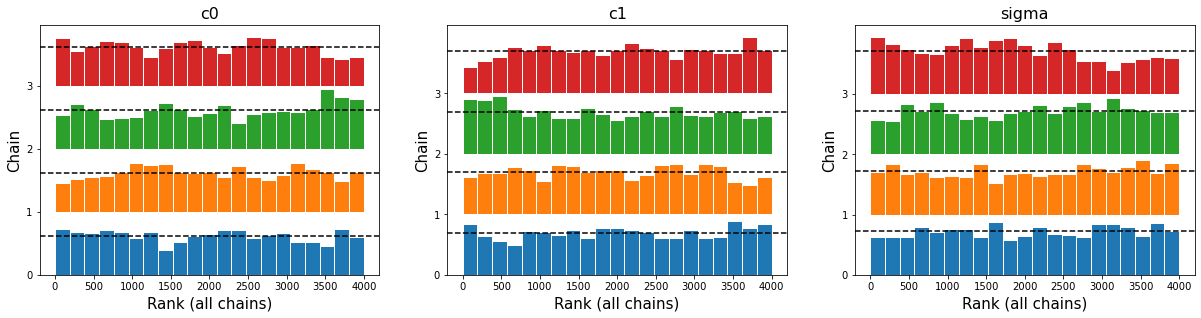

In [143]:
#Using the sampler to sample from our defined model, above. 
with normal_model: 
    normal_inference_all = pm.sample()

#Displaying our rank plots of 4 total chains per distribution. We are looking for uniformity for correct sampling.
az.plot_rank(normal_inference_all, var_names=['c0', 'c1', 'sigma'])

#Displaying summary statistics of our samples for each distributed variable, c0, c1, and sigma. (Posterior)
az.summary(normal_inference_all, var_names=['c0', 'c1', 'sigma'])


### Evaluating Summary Statistics and Rank Plots

**R-Hat** values, which display the quality of sampling among chains, all lie within 1.00-1.01 for c0, c1, and sigma, which is our "goal" value. Goal R-Hat values tell us that after initialization (random start point for all chains), sampling continued uniformly. 

**Uniformity** is seen visually on all three distributions in each of the four chains. The histograms vary across samples, but balance one another to maintain a general uniform shape. 

**ESS Values** range for each distributed variable. They describe the effectiveness of a sample chain. We want the ESS values to be large, at least a few hundred per 2000 samples. The rule of thumb is 200 per 2000 samples (Session 6 Pre-Class Workbook). The ESS values presented in the descriptive stats are for 4000 samples per chain, so we would expect at least 400 per 4000 samples. This is met in all ESS values. The sampler did a much better job than the rule of thumb, meaning that it is working properly. 

**Mean Values** are sitting at 21.567 for c0, 4.558 for c1, and 70.982 for sigma in this run of the sampler. These values are single-value summaries of the posterior. These allow us to visualize roughly what our model would look like, but do not communicate how much uncertainty is left in the mean. A credible interval will give us more context to these single-value statistics: 


#### Credible Interval 

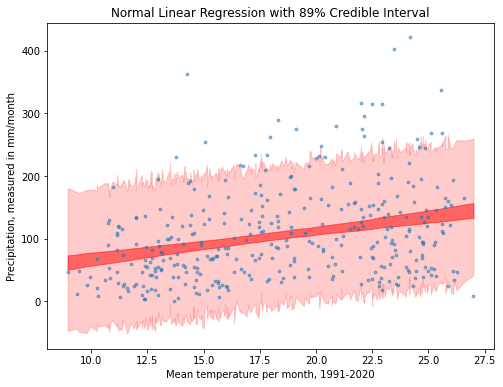

In [136]:
#Using our samples from the model as training data to form our mu_predictive data, to see 89% intervals of the mu
mu1_pred = tn.posterior["mu"]
tn_thinned = tn.sel(draw=slice(None, None, 5))
with normal_model:
    mm1_pred = pm.sample_posterior_predictive(tn_thinned)
    
#Labeling Figure  
plt.figure(figsize=(8, 6))
plt.title('Normal Linear Regression with 89% Credible Interval')
plt.xlabel('Mean temperature per month, 1991-2020')
plt.ylabel('Precipitation, measured in mm/month')

#Plotting the CE for the Normal Model 
ax = az.plot_hdi(media, mu1_pred, color='r', smooth=False)
az.plot_hdi(media, mm1_pred.posterior_predictive["likelihood"], ax=ax, color = 'r', smooth=False, fill_kwargs={"alpha": .2} )
plt.scatter(media, mm, s=8, alpha=0.5)

#Calling Plot 
plt.show()


### Normal Credible Interval: Discussion

Credible intervals appear similar to frequentist confidence intervals. However, credible intervals provide context to our unknown parameters that we are estimating, or the linear regression in our Posterior (above). Defined at 89%, this area shaded in orange tells us that there is an 89% chance of obtaining a new value within these bounds, plotted using the  posterior-predictive capability in the arviz package.

This interval is large, but it does seem correct upon glance as it looks to encompass a large portion of our training data (the data in the imported csv files from the BA government), likely around 89% of it. This expands on the posterior summary statistics, as they are only single-value summaries. The summary values do not describe the deviation as well as the credible interval visually displays above. Visualizing our credible interval is necessary to understand the implications of our model for future use. Becuase there is such large variation, it looks that there is not the strongest correlation between the linear expression regression (y = mx + b). 


### Model Definition: Student T  

This is the second model, the Student T model, that we will be comparing to the Normal model. The Student T model is much more accommodating to outliers as it contains a new variable, nu, that adjusts tail width.

All of the previous priors remain, except for our likelihood function using pm.StudentT and our new variable, nu: 

**Nu** is defined using a half normal to remain positive since nu > 0. It is the positive half of the Normal(0, 30^2) distribution. The scale parameter is set to 30 so the prior "allows for values of nu that make the T distribution look like the Normal distribution" that is, the model will regress to the mean when nu becomes large (Session 8 Pre-Class Workbook). The model can adapt to the amount of outliers, providing us with an adjusted version of the Normal. 


In [137]:
#Defining our second model for comparison, the Student T distribution: 
with pm.Model() as t_model: 
    
    #Priors, using the same as the last model (with same reasoning as provided)
    c0 = pm.Uniform ('c0', lower=0, upper=100) 
    c1 = pm.Normal('c1', mu=0, sigma=5)
    sigma = pm.Uniform('sigma', lower=0, upper=100)
    
    #For the T distribution 
    nu = pm.HalfNormal('nu', sigma=30)
    
    #Data 
    x = pm.MutableData('x', media)
    y = pm.MutableData('y', mm)
    
    # Regression mean
    mu = pm.Deterministic('mu', c0 + c1 * x)
    
    # Likelihood
    pm.StudentT('likelihood', nu=nu, mu=mu, sigma=sigma, observed=y)
    
    #Samples used for Part 2 
    tt = pm.sample(1000, tune=1000)
    
    #Samples used for Part 3
    t_inference = pm.sample(target_accept=0.99)
    pm.sample_posterior_predictive(t_inference, extend_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/graysonmessenger/opt/anaconda3/lib/python3.9/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c0, c1, sigma, nu]


/Users/graysonmessenger/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/graysonmessenger/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/graysonmessenger/opt/anaconda3/lib/python3.9/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary

/Users/graysonmessenger/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/graysonmessenger/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/graysonmessenger/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/graysonmessenger/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/graysonmessenger/opt/anaconda3/lib/python3.9/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c0, c1, sigma, nu]


/Users/graysonmessenger/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/graysonmessenger/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
The acceptance probability does not match the target. It is 0.8909, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.702, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
c0,20.910,11.463,0.331,35.583,0.424,0.330,759.0,474.0,1.01
c1,4.221,0.625,3.367,5.313,0.023,0.017,748.0,446.0,1.01
sigma,60.012,4.284,52.786,66.282,0.165,0.118,687.0,817.0,1.00
nu,8.516,5.001,3.201,13.039,0.170,0.120,868.0,1077.0,1.00


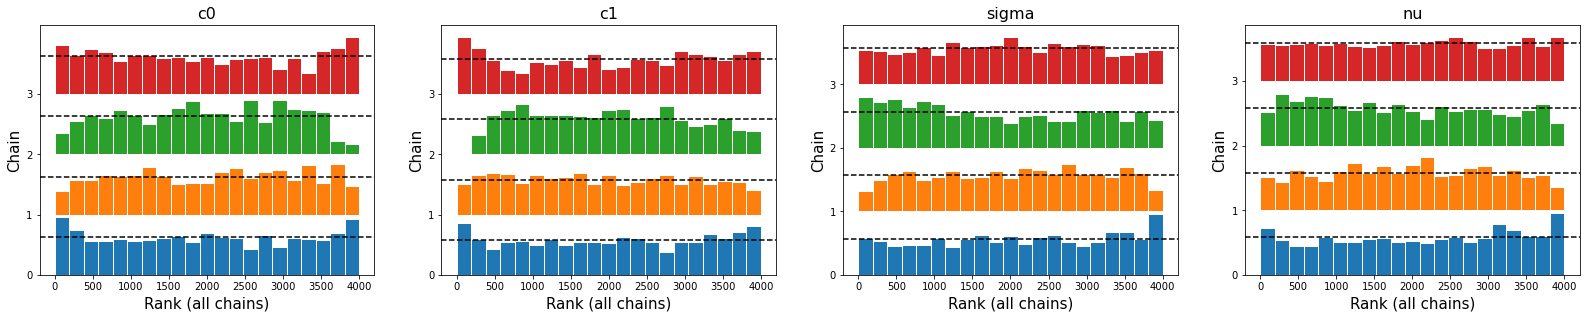

In [138]:
#Using the sampler to sample from our defined model, above. 
with t_model:
    t_inference_all = pm.sample()

#Displaying our rank plots of 4 total chains per distribution. We are looking for uniformity for correct sampling.
az.plot_rank(t_inference_all, var_names=['c0', 'c1', 'sigma', 'nu'])

#Displaying summary statistics of our samples for each distributed variable, c0, c1, sigma, and nu. (Posterior)
az.summary(t_inference_all, var_names=['c0', 'c1', 'sigma', 'nu'])

### Evaluating Summary Statistics and Rank Plots

**R-Hat:** explained above. These four R-Hat values look perfect, all at 1.00. This is our goal value; the sampler displays quality.

**Uniformity:** explained above. The histograms vary across bins of samples, but balance one another to maintain a general uniform shape. 

**ESS Values:** explained above. These ESS values, all very large, tell us that the sampler did a much better job than the rule of thumb. Therefore, the sampler is working properly. 

**Mean Values** are sitting at 2.244 for c0, 5.221 for c1, 60.899 for sigma, and 11.760 for nu in this run of the sampler. Again, these values are single-value summaries of the posterior. We can roughly visualize what our model would look like, but the values do not communicate how much uncertainty is left in the mean. A credible interval will give us more context to these single-value statistics. 


#### Credible Interval 

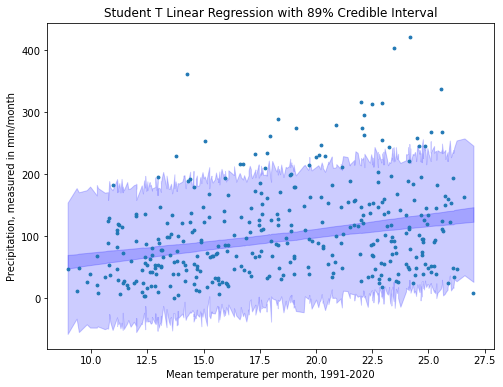

In [139]:
#Credible Interval using Student T distribution 

#Using our samples from the model as training data to form our mu_predictive data, to see 89% intervals of the mu
mu_pred = tt.posterior["mu"]
tt_thinned = tt.sel(draw=slice(None, None, 5))
with t_model:
    mm_pred = pm.sample_posterior_predictive(tt_thinned)
    
    
#Labeling Figure 
plt.figure(figsize=(8, 6))
plt.title('Student T Linear Regression with 89% Credible Interval')
plt.xlabel('Mean temperature per month, 1991-2020')
plt.ylabel('Precipitation, measured in mm/month')

#Plotting the CE for the Student T model
ax = az.plot_hdi(media, mu_pred, color='b', smooth=False, fill_kwargs={"alpha": .2})
az.plot_hdi(media, mm_pred.posterior_predictive["likelihood"], ax=ax, color='b', smooth=False, fill_kwargs={"alpha": .2})
plt.scatter(media, mm, s=8)

#Calling Plot 
plt.show()


#### Student T Credible Interval: Discussion

As noted above with the Normal model, this 89% credible interval provides context to our unknown parameters that we are estimating -- the linear regression in our Posterior (above). 

Again, this interval is large, but it does seem correct upon glance as it looks to encompass a large portion of our training data, similar to the Normal, likely around 89% of it. 

This expands on the posterior summary statistics, as they are only single-value summaries. The summary values do not describe the deviation as well as the credible interval visually displays above. Visualizing our credible interval is necessary to understand the implications of our model for future use. Becuase there is such large variation, it looks that there is not the strongest correlation between the linear expression regression (y = mx + b). 

### Credible Interval Overlay 

Before comparing the Normal and Student T models using PSIS to quantify the best model in Part 3, I am going to display an overlay of the credible interval plots for both the Normal and Student T plots. This way, we can visually compare before delving into a quantifiable comparison. 

I overlayed the Red for Normal and Blue for Student T so they overlay purple. The purple areas are overlapping, which is displayed below: 

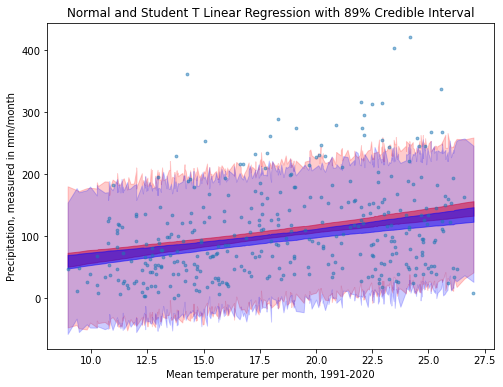

In [140]:
#Labeling Figure 
plt.figure(figsize=(8, 6))
plt.title('Normal and Student T Linear Regression with 89% Credible Interval')
plt.xlabel('Mean temperature per month, 1991-2020')
plt.ylabel('Precipitation, measured in mm/month')

#Plotting the CE for the Normal model 
ax = az.plot_hdi(media, mu1_pred, color='r', smooth=False)
az.plot_hdi(media, mm1_pred.posterior_predictive["likelihood"], ax=ax, color = 'r', smooth=False, fill_kwargs={"alpha": .2} )

#Plotting the CE for the Student T model
ax = az.plot_hdi(media, mu_pred, color='b', smooth=False)
az.plot_hdi(media, mm_pred.posterior_predictive["likelihood"], ax=ax, color='b', smooth=False, fill_kwargs={"alpha": .2})

#Plotting training data 
plt.scatter(media, mm, s=8, alpha=0.5)

#Calling Plot 
plt.show()



### Credible Interval Overlay Discussion 

From a visual perspective, this plot tells us a few things. 

Firstly, that the two models have very similar 89% CE intervals. This is due to their identical priors outside of the nu variable in the Student T distribution. These two models are very similar. 

Secondly, it is visible that the Normal model has a slightly higher model, sitting above the Student T model by a bit but still largely overlapping. This could be due to the expected "pull" that we know outliers have on the Normal model versus the accomodating nature of the Student T model. This seems plausible, as the outlying data points from our original set lie above the distributions, likely to pull the Normal model "up". 

Further analysis and model comparison in Part 3. 

## Part 3: Model Comparison 
### Comparing the Normal and Student T Models Quantitatively 

Using PSIS leave-one-out cross-validation (PSIS-LOO-CV), I compared the two models. This method identifies the "best" model for our scenario and the training data provided. 

Beginning with the "CV" portion of this acronym, **Cross-Validation** is the act of leaving a portion of data out and evaluating our model based on the data that is "left". Each section that is left out is called a "fold". There can be many folds per data set, the maximum being a "leave one out" method. 

This is the second part of the acronym, "LOO", or **Leave-One-Out**. Leave-one-out cross-validation -- in theory -- uses the maximum number of folds, leaves out an individual point, evaluates the posterior model, and moves to the next point. LOO is done quickly not by evaluating each individual posterior, but by using the "importance", or weighted measurement of each observation. 

Lastly, this is where "PSIS", **Pareto-smoothed Importance Sampling Cross-Validation**, is useful. An observation has high importance if, when removed, the model is changed with relative significance; these are unexpected observations. Low-importance observations are relatively expected. Estimating the model's out-of-sample accuracy using weighted observations, PSIS approximates the cross-validation score without comparing individual posteriors. It also provides feedback, visible in the chart below, about its own reliability alongside quantitative comparisons: 

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Student-T,0,-2005.529416,4.250009,0.000000,0.884515,17.114450,0.000000,False,log
Normal,1,-2012.545801,3.354231,7.016385,0.115485,17.828412,4.678506,False,log


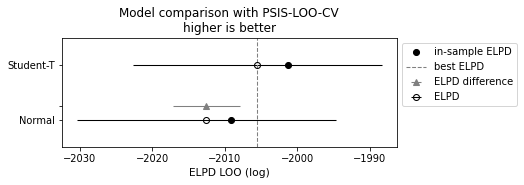

In [147]:
#Defining our two models, sampled from earlier in the "model definition" Part 1.
inferences = {'Normal': normal_inference, 'Student-T': t_inference}

#Comparing LOO values 
df = az.compare(inferences, ic='loo')
display(df)
az.plot_compare(df)

#Plotting the results
plt.title('Model comparison with PSIS-LOO-CV\nhigher is better')
plt.xlabel('ELPD ' + df.columns[1].upper() + ' (log)')
plt.legend(['in-sample ELPD', 'best ELPD', 'ELPD difference', 'ELPD'], loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

### Model Comparison Discussion 

Each row in the plot above signifies a different model, with the Student T on top and the Normal below. 
ELPD stands for Expected Log Pointwise Predictive Density. Cross-validataion estimates this, it is a predictive fit for new data. This value is the expected value of the log likelihood function given all of our data points. The log likelihood function is (roughly) the likelihood of predicting a datum given the posterior. 
(PSIS discussion via Session 12 Class Session)

Comparison using PSIS-LOO-CV provides us with a few variables we can compare between models: 

**Dots: in-sample ELPD and ELPD:** the closed dots represent the "training data", the ELPD without using LOO; and the open dots represent the "test data", the ELPD after using LOO. The distance betwen these two dots maps the difference between the predictive accuracy with in-sample: using all data to train the model and how well it predicts new data; and our data using LOO: using LOO to train the model and how well it predicts new data. The in-sample training values usually over-fit the model exactly to the data (as they do not use LOO), lacking predictive power or generalizability. Therefore, we use the open ELPD dot to guague the generalizability and best fit of model. 

**Best ELPD:** the best ELPD line is the dotted vertical line, cut through the open ELPD dot. As mentioned above, this is the best indicator of a generalizable, strong model for the scenario. Originating at the top of the plot with the Student T distribution indicates it as the better fit. The Normal, below, is nearby, but its ELPD is not close to the "best ELPD" line. 

**ELPD difference:** the closeness of the Normal distribution to the Student T model is visualized with the triangle "ELPD difference" and its bars. The triangle on the Normal tells us the "difference" between the two values of the two open dots, ELPD using LOO, that are being compared. The interval is a 95% credible interval of the difference between the two values of the models. Given that the interval for the Normal does not overlap with the "best ELPD", we can differentiate between the two models and select the Student T as the better model. 

**Results:** 
Using the comparison figure: given that the "ELPD difference interval" for the Normal does not overlap with the "best ELPD", we can differentiate between the two models and select the Student T as the better model (visually). 

Additionally, the Student T model is on "top" in the table, with the rank 0 over the Normal rank of 1. In addition to the comparision figure above, we can compare the "weight" values in the table. Our Student T is about 0.88 while the Normal is about 0.12. These weights describe the predictive quality/ability of each model, set up in a way that would allow us to use all of the models given a weighted sum of the predictions from the different models. These weights indicate the usage of each model (Student T and Normal) if we want to make the most accurate predictions. Given that the weight is much higher for Student T, 0.88 versus 0.12, I would designate Student T as the better model. 